In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define paths for images and masks
image_folder_path = "/content/drive/MyDrive/komimages"
mask_folder_path = "/content/drive/MyDrive/kommasks"

# Assuming you have images and masks in lists
image_files = os.listdir(image_folder_path)
mask_files = os.listdir(mask_folder_path)

# Hyperparameters
input_shape = (256, 256, 3)  # Adjust according to your image dimensions
batch_size = 8
epochs = 15



In [ ]:
epochs=1

In [ ]:
# Data preprocessing
def load_data(image_files, mask_files, image_folder, mask_folder):
    images = []
    masks = []
    for img_file in image_files:
        if img_file.endswith(".jpg"):
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, f"mask_{img_file}")
            image = img_to_array(load_img(img_path, target_size=input_shape[:2]))
            mask = img_to_array(load_img(mask_path, color_mode="grayscale", target_size=input_shape[:2]))
            images.append(image)
            masks.append(mask)
    return np.array(images), np.array(masks)

images, masks = load_data(image_files, mask_files, image_folder_path, mask_folder_path)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Build the model
model = DeepLabV3Plus(input_shape)

# Compile the model
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=3, validation_data=(X_test, y_test))


Epoch 1/3
30/30 [==============================] - 8s 263ms/step - loss: -96436.8828 - accuracy: 0.3553 - val_loss: -72013.1484 - val_accuracy: 0.3838
Epoch 2/3
30/30 [==============================] - 8s 267ms/step - loss: -99571.2500 - accuracy: 0.3017 - val_loss: -117449.0938 - val_accuracy: 0.2748
Epoch 3/3
30/30 [==============================] - 8s 266ms/step - loss: -105014.4609 - accuracy: 0.2680 - val_loss: -120052.6250 - val_accuracy: 0.4257


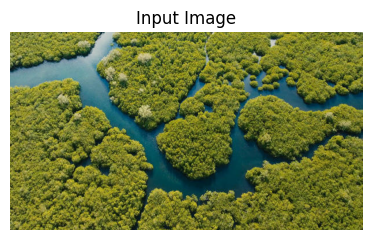

In [ ]:

import cv2
import matplotlib.pyplot as plt

# Load the image you want to predict (replace 'your_image.jpg' with the path to your image)
image_path = '/content/drive/MyDrive/testimage.jpg'
input_image = cv2.imread(image_path)  # Load the image using OpenCV

# Ensure the image has the correct data type (CV_8U)
input_image = input_image.astype(np.uint8)

# Convert the input image from BGR to RGB color space for displaying with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display the input image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_rgb)
plt.title('Input Image')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 24ms/step


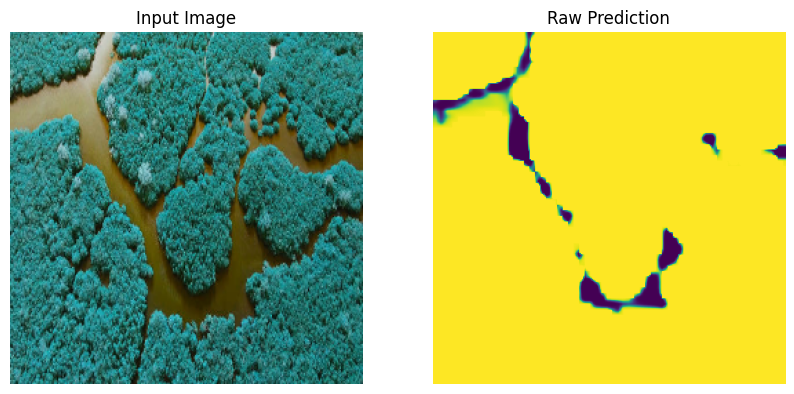

In [ ]:
# Assuming you have your model loaded and named 'model'
# Make sure 'input_image' contains the loaded image
IMG_WIDTH=256
IMG_HEIGHT=256
# Preprocess the input image (resize it to match the model's input size and normalize)
input_image = cv2.resize(input_image, (IMG_WIDTH, IMG_HEIGHT))
#input_image = input_image / 255.0  # Normalize pixel values to the range [0, 1]

# Make a prediction using the model
prediction = model.predict(np.expand_dims(input_image, axis=0))

# Visualize the prediction
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap='viridis', vmin=0, vmax=1)  # Display the raw prediction
plt.title('Raw Prediction')
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 112ms/step


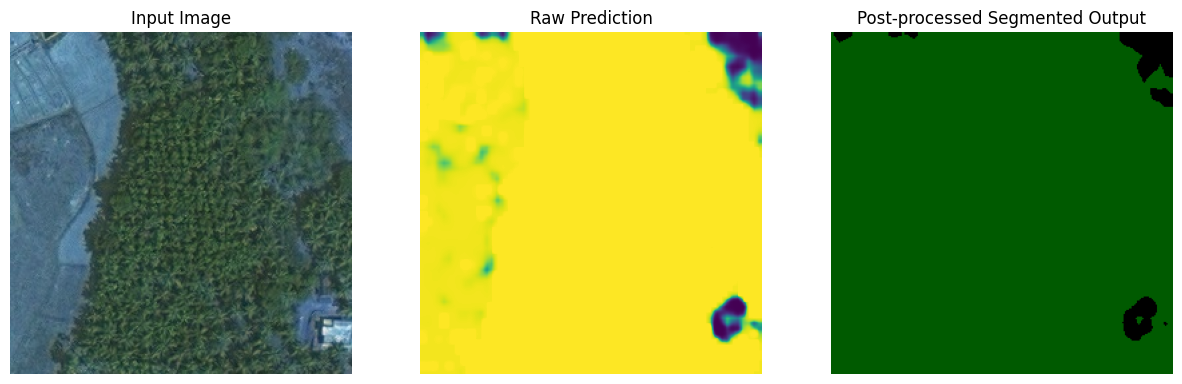

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the post-processing function
def post_process_segmentation(segmented_output):
    # Threshold the segmented output to separate green areas
    _, thresh = cv2.threshold(segmented_output, 0.5, 255, cv2.THRESH_BINARY)
    thresh = cv2.merge((thresh, thresh, thresh))  # Convert to 3-channel image

    green_color = [0, 90, 0]
    black_color = [0, 0, 0]

    green_mask = np.where((thresh == [255, 255, 255]), green_color, black_color)

    return green_mask


# Load the image you want to predict (replace 'your_image.jpg' with the path to your image)
image_path = '/content/drive/MyDrive/images/3484_sat_34.jpg'
input_image = cv2.imread(image_path)  # Load the image using OpenCV

# Visualize the input image, raw prediction, and post-processed segmented output
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')
# Ensure the image has the correct data type (CV_8U)
input_image = input_image.astype(np.uint8)

# Assuming you have your model loaded and named 'model'
# Make sure 'input_image' contains the loaded image
IMG_WIDTH = 256
IMG_HEIGHT = 256
# Preprocess the input image (resize it to match the model's input size and normalize)
input_image = cv2.resize(input_image, (IMG_WIDTH, IMG_HEIGHT))

# Make a prediction using the model
prediction = model.predict(np.expand_dims(input_image, axis=0))

segmented_output = post_process_segmentation(prediction[0, :, :, 0])



plt.subplot(1, 3, 2)
plt.imshow(prediction[0, :, :, 0], cmap='viridis', vmin=0, vmax=1)  # Display the raw prediction
plt.title('Raw Prediction')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmented_output)
plt.title('Post-processed Segmented Output')
plt.axis('off')

plt.show()


In [ ]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_test)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (y_test > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")


2/2 [==============================] - 0s 315ms/step
Test Accuracy: 78.5589599609375%
F1-Score: 0.7839397621916622
Precision: 0.6461540476327271


In [ ]:
new_model_name = 'deeplabv3pus_kaggledataset.h5'
model.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
